In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# Load the CSV file
data = pd.read_csv('player_stats.csv')

In [ ]:
# Step 1: Clean data
# Convert height and weight to numeric
data['height'] = data['height'].astype(str)
data['weight'] = data['weight'].astype(str)
data['wage'] = data['wage'].astype(str)

data['height'] = data['height'].str.split().str[0]
data['weight'] = data['weight'].str.split().str[0]
data['wage'] = data['wage'].str.replace('$', '').str.strip()

# Convert to float
data['height'] = data['height'].astype(float)
data['weight'] = data['weight'].astype(float)
data['wage'] = data['wage'].astype(float)

data.head()

/var/folders/cr/4yk6l09s60g0c2zhv86vl4gc0000gn/T/ipykernel_350/1382888035.py:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data['wage'] = data['wage'].str.replace('$', '').str.strip()


,name,overall_score,position_score,height,weight,pref_foot,birthdate,age,pref_pos,work_rate,...,GK Handling,GK Kicking,GK Reflexes,ball_skill_avg,defence_avg,mental_avg,passing_avg,physical_avg,shooting_avg,goalkeeper_avg
0,Erling Haaland,91,94,195.0,94.0,Left,"July 21, 2000",24.0,ST,High / Medium,...,14,13,7,80.5,NaN,80.166667,59.000000,83.714286,84.000,10.4
1,Kylian Mbappé,91,94,182.0,75.0,Right,"Dec. 20, 1998",25.0,STLW,High / Low,...,5,7,6,92.5,NaN,76.500000,78.333333,88.857143,82.125,8.4
2,Kevin De Bruyne,91,91,181.0,75.0,Right,"June 28, 1991",33.0,CMCAM,High / Medium,...,13,5,13,89.0,NaN,84.000000,94.333333,75.714286,83.125,11.2
3,Harry Kane,90,90,188.0,89.0,Right,"July 28, 1993",31.0,ST,High / High,...,10,11,11,84.5,NaN,81.333333,85.000000,75.857143,86.500,10.8
4,Thibaut Courtois,90,90,199.0,96.0,Left,"May 11, 1992",32.0,GK,Medium / Medium,...,89,76,93,18.0,NaN,41.500000,27.333333,54.000000,22.375,86.6


In [ ]:
data = data.dropna(subset=['wage'])
data.head()

,name,overall_score,position_score,height,weight,pref_foot,birthdate,age,pref_pos,work_rate,...,GK Handling,GK Kicking,GK Reflexes,ball_skill_avg,defence_avg,mental_avg,passing_avg,physical_avg,shooting_avg,goalkeeper_avg
0,Erling Haaland,91,94,195.0,94.0,Left,"July 21, 2000",24.0,ST,High / Medium,...,14,13,7,80.5,NaN,80.166667,59.000000,83.714286,84.000,10.4
1,Kylian Mbappé,91,94,182.0,75.0,Right,"Dec. 20, 1998",25.0,STLW,High / Low,...,5,7,6,92.5,NaN,76.500000,78.333333,88.857143,82.125,8.4
2,Kevin De Bruyne,91,91,181.0,75.0,Right,"June 28, 1991",33.0,CMCAM,High / Medium,...,13,5,13,89.0,NaN,84.000000,94.333333,75.714286,83.125,11.2
3,Harry Kane,90,90,188.0,89.0,Right,"July 28, 1993",31.0,ST,High / High,...,10,11,11,84.5,NaN,81.333333,85.000000,75.857143,86.500,10.8
4,Thibaut Courtois,90,90,199.0,96.0,Left,"May 11, 1992",32.0,GK,Medium / Medium,...,89,76,93,18.0,NaN,41.500000,27.333333,54.000000,22.375,86.6


In [ ]:
data = data.drop('defence_avg',axis=1)
data = data.drop('value',axis=1)
data = data.drop('Marking',axis=1)
#df.drop('B', axis=1, inplace=True)

In [ ]:
#categorical
categorical_columns = ['pref_foot', 'birthdate', 'pref_pos', 'work_rate', 'joined_club', 'contract_expires']
label_encoder = LabelEncoder()

for column in categorical_columns:
    data[column] = label_encoder.fit_transform(data[column].astype(str))


In [ ]:
data.head()

,name,overall_score,position_score,height,weight,pref_foot,birthdate,age,pref_pos,work_rate,...,GK Diving,GK Handling,GK Kicking,GK Reflexes,ball_skill_avg,mental_avg,passing_avg,physical_avg,shooting_avg,goalkeeper_avg
0,Erling Haaland,91,94,195.0,94.0,0,2813,24.0,656,2,...,7,14,13,7,80.5,80.166667,59.000000,83.714286,84.000,10.4
1,Kylian Mbappé,91,94,182.0,75.0,1,1246,25.0,681,1,...,13,5,7,6,92.5,76.500000,78.333333,88.857143,82.125,8.4
2,Kevin De Bruyne,91,91,181.0,75.0,1,3443,33.0,178,2,...,15,13,5,13,89.0,84.000000,94.333333,75.714286,83.125,11.2
3,Harry Kane,90,90,188.0,89.0,1,2926,31.0,656,0,...,8,10,11,11,84.5,81.333333,85.000000,75.857143,86.500,10.8
4,Thibaut Courtois,90,90,199.0,96.0,0,4200,32.0,258,8,...,85,89,76,93,18.0,41.500000,27.333333,54.000000,22.375,86.6


In [ ]:
X = data.drop(['name', 'wage'], axis=1)
y = data['wage']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
model = xgb.XGBRegressor(random_state=42)
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

In [ ]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mse, r2

(90.90786482044345, 0.7279767794583916)

<Figure size 1000x800 with 0 Axes>

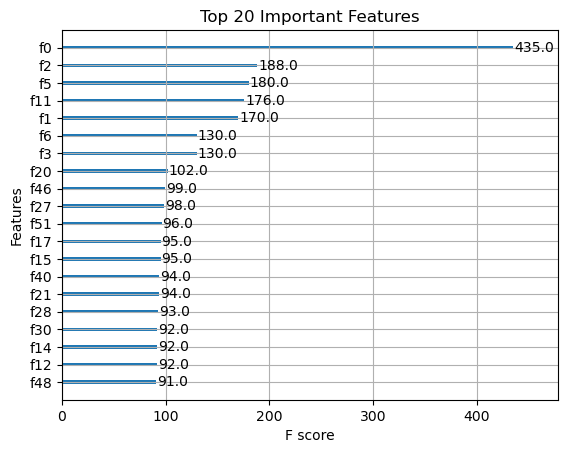

In [ ]:
# Visualize feature importance
plt.figure(figsize=(10, 8))
plot_importance(model, max_num_features=20)
plt.title("Top 20 Important Features")
plt.show()

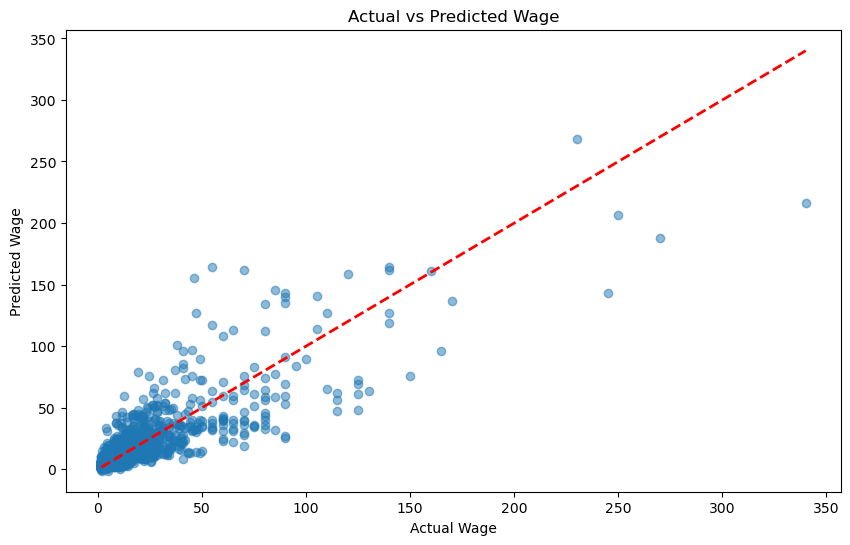

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Wage")
plt.ylabel("Predicted Wage")
plt.title("Actual vs Predicted Wage")
plt.show()